<h1> Customer Segmentation using K- Means Clustering </h1>

<h3> Load libraries </h3>

In [58]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
import warnings
warnings.filterwarnings('ignore')

<h3> Load data from customers.xlxs </h3>

In [60]:
!!cd

['S:\\Data Science\\Customer Segmentation']

In [61]:
#df = pd.read_excel("customers.xlsx")

In [62]:
#df.to_csv("output.csv", index = False)

In [63]:
df = pd.read_csv("output.csv")

<h3> Understanding Data </h3>

In [64]:
df.sample(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
277520,516343,22617,BAKING SET SPACEBOY DESIGN,3,2010-07-20 09:45:00,4.95,14922.0,United Kingdom
245969,513199,21527,RED RETROSPOT TRADITIONAL TEAPOT,1,2010-06-22 16:21:00,16.98,NaN,United Kingdom
88876,497795,22271,FELTCRAFT DOLL ROSIE,6,2010-02-12 12:51:00,2.95,16954.0,United Kingdom
330484,521646,21703,BAG 125g SWIRLY MARBLES,10,2010-09-07 13:20:00,0.85,NaN,United Kingdom
269963,515504,20738,GREEN MINI TAPE MEASURE,100,2010-07-13 10:51:00,0.72,16013.0,United Kingdom
376268,525752,21430,SET/3 RED GINGHAM ROSE STORAGE BOX,1,2010-10-07 10:07:00,3.75,NaN,United Kingdom
155805,504160,82486,WOOD S/3 CABINET ANT WHITE FINISH,2,2010-04-11 15:54:00,7.95,15555.0,United Kingdom
41265,492784,85097B,BLUE ROCKING SINGING CANARY,1,2009-12-18 17:24:00,3.75,17841.0,United Kingdom
152238,503867,22526,WHEELBARROW FOR CHILDREN,1,2010-04-08 11:16:00,12.75,13712.0,United Kingdom
177729,506250,84761,IVORY HANGING BIRD PLANTER,2,2010-04-28 13:34:00,2.55,16327.0,United Kingdom


In [70]:
df.shape

(525461, 8)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      525461 non-null  object 
 1   StockCode    525461 non-null  object 
 2   Description  522533 non-null  object 
 3   Quantity     525461 non-null  int64  
 4   InvoiceDate  525461 non-null  object 
 5   Price        525461 non-null  float64
 6   Customer ID  417534 non-null  float64
 7   Country      525461 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.1+ MB


In [43]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

<h3> Converting the data type from object to date time </h3>

In [44]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

<h3> Removing transactions with null customer ID </h3>

In [45]:
df = df.dropna(subset=['Customer ID'])

<h3>Removing transactions with negative count</h3>

In [46]:
df = df[(df['Quantity']>0) & (df['Price']>0)]

In [47]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [48]:
df.shape

(407664, 8)

<h3> Calculate Recency</h3>

In [49]:
# Recency: Calculate days since last purchase
reference_date = df['InvoiceDate'].max()
Recency = df.groupby("Customer ID")["InvoiceDate"].apply(lambda x: (reference_date - x.max()).days).rename("Recency")
print(type(Recency))
Recency.head(5)
print(Recency.shape)

<class 'pandas.core.series.Series'>
(4312,)


<h3> Calculate Frequency</h3>

In [50]:
# Frequency :  Count number of purchases per customer
Frequency = df.groupby('Customer ID')['InvoiceDate'].nunique().rename('Frequency')
Frequency.head(5)
print(Frequency.shape)

(4312,)


<h3>Calculate Monetary value </h3>

In [51]:
#monetary
df['Monetary'] = abs(df["Quantity"])*df["Price"]
Monetary_Value = df.groupby('Customer ID')['Monetary'].sum().rename('Monetary_Value')
Monetary_Value.head(5)
print(Monetary_Value.shape)

(4312,)


<h3> Merging all the metrics into one dataframe </h3>

In [55]:
rfm = pd.concat([Recency, Frequency, Monetary_Value], axis=1)

# Renaming the columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Display the merged DataFrame
print(rfm.shape)
rfm.head()
rfm.columns

(4312, 3)


Index(['Recency', 'Frequency', 'Monetary'], dtype='object')

In [56]:
print(rfm.loc[12346.0])

Recency      164.00
Frequency     11.00
Monetary     372.86
Name: 12346.0, dtype: float64


<h3> Standarize data </h3>

In [27]:
# Normalize the RFM metrics
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
rfm_normalized = rfm.copy()
rfm_normalized[['Recency', 'Frequency', 'Monetary']] = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])
print(rfm_normalized.head())

              Recency  Frequency  Monetary
Customer ID                               
12346.0      0.439678   0.049261  0.001059
12347.0      0.005362   0.004926  0.003782
12348.0      0.195710   0.000000  0.000628
12349.0      0.112601   0.009852  0.007642
12351.0      0.026810   0.000000  0.000853


In [28]:
# Finding the maximum values of each metric
max_values = rfm_normalized[['Recency', 'Frequency', 'Monetary']].max()

# Finding the minimum values of each metric
min_values = rfm_normalized[['Recency', 'Frequency', 'Monetary']].min()
print(max_values, min_values)

Recency      1.0
Frequency    1.0
Monetary     1.0
dtype: float64 Recency      0.0
Frequency    0.0
Monetary     0.0
dtype: float64


<h3>Elbow Method</h3>

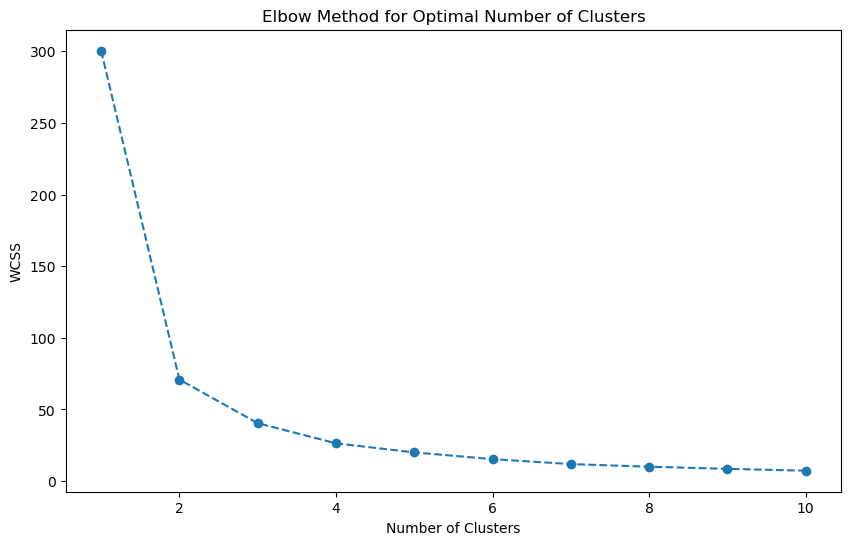

In [29]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_normalized[['Recency', 'Frequency', 'Monetary']])
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()


<h3>Silhouette Score</h3>

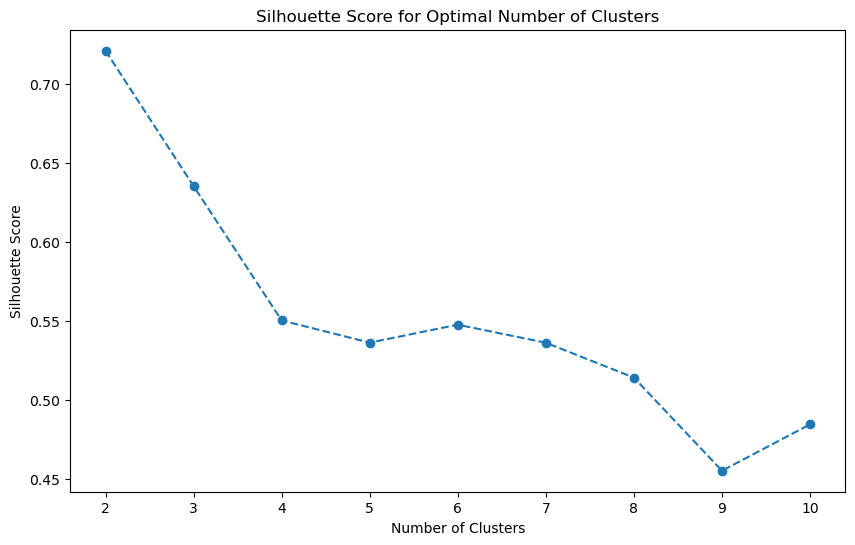

In [322]:
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(rfm_normalized[['Recency', 'Frequency', 'Monetary']])
    silhouette_avg = silhouette_score(rfm_normalized[['Recency', 'Frequency', 'Monetary']], cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.show()


<h3>Based on the elbow method and silhouette score, i choosed 4 as the optimal number of clusters</h3>

In [323]:
optimal_clusters = 4 
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
rfm_normalized['Cluster'] = kmeans.fit_predict(rfm_normalized[['Recency', 'Frequency', 'Monetary']])
print(rfm_normalized.info()) 
rfm_normalized.head(5)

<class 'pandas.core.frame.DataFrame'>
Index: 4312 entries, 12346.0 to 18287.0
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    4312 non-null   float64
 1   Frequency  4312 non-null   float64
 2   Monetary   4312 non-null   float64
 3   Cluster    4312 non-null   int32  
dtypes: float64(3), int32(1)
memory usage: 151.6 KB
None


,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
12346.0,0.439678,0.049261,0.001059,1
12347.0,0.005362,0.004926,0.003782,0
12348.0,0.195710,0.000000,0.000628,2
12349.0,0.112601,0.009852,0.007642,0
12351.0,0.026810,0.000000,0.000853,0


<h3>Calculate mean values for each cluster</h3>

In [324]:
cluster_analysis = rfm_normalized.groupby('Cluster').mean()
print(cluster_analysis)

          Recency  Frequency  Monetary
Cluster                               
0        0.050298   0.027776  0.009322
1        0.502982   0.005232  0.002076
2        0.207288   0.010387  0.003526
3        0.818699   0.001696  0.001506


<h3> Centroids </h3>

In [325]:
kmeans.cluster_centers_

array([[0.05018093, 0.02776425, 0.00931288],
       [0.50298231, 0.0052316 , 0.002076  ],
       [0.20708889, 0.01045359, 0.00355747],
       [0.818699  , 0.0016957 , 0.00150596]])

<h3>Visualize the clusters with bar graphs</h3>

<Figure size 1200x800 with 0 Axes>

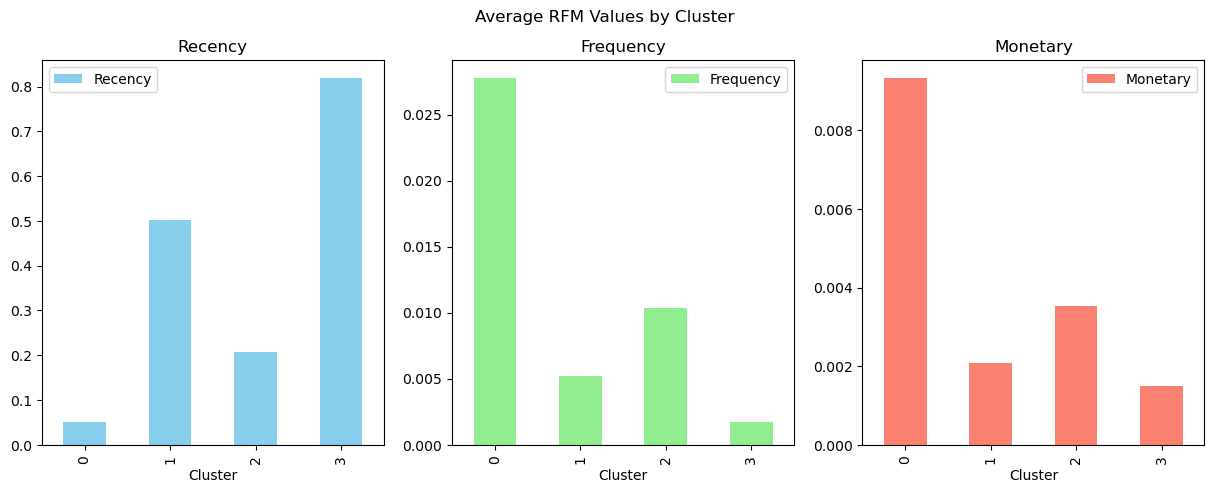

In [326]:
plt.figure(figsize=(12, 8))
cluster_analysis[['Recency', 'Frequency', 'Monetary']].plot(kind='bar', subplots=True, layout=(1, 3), figsize=(15, 5), color=['skyblue', 'lightgreen', 'salmon'])
plt.suptitle('Average RFM Values by Cluster')
plt.show()

<h3>Segment mapping based on analysis</h3>

In [257]:
segment_map = {
    0: 'Best Customers',
    1: 'Big Spenders',
    2: 'Loyal Customers',
    3: 'Lost Cheap Customers'
}

In [272]:
rfm_normalized['Segment'] = rfm_normalized['Cluster'].map(segment_map)
print(rfm_normalized.head())

              Recency  Frequency  Monetary  Cluster          Segment
Customer ID                                                         
12346.0      0.439678   0.049261  0.001059        1     Big Spenders
12347.0      0.005362   0.004926  0.003782        0   Best Customers
12348.0      0.195710   0.000000  0.000628        2  Loyal Customers
12349.0      0.112601   0.009852  0.007642        0   Best Customers
12351.0      0.026810   0.000000  0.000853        0   Best Customers


<h3> Analyze the final segments </h3>

In [282]:
segment_analysis = rfm_normalized.groupby('Segment').mean()
print(segment_analysis)

                       Recency  Frequency  Monetary  Cluster
Segment                                                     
Best Customers        0.050298   0.027776  0.009322      0.0
Big Spenders          0.502982   0.005232  0.002076      1.0
Lost Cheap Customers  0.818699   0.001696  0.001506      3.0
Loyal Customers       0.207288   0.010387  0.003526      2.0


<h3>Visualize segments with bar graphs</h3>

<Figure size 1200x800 with 0 Axes>

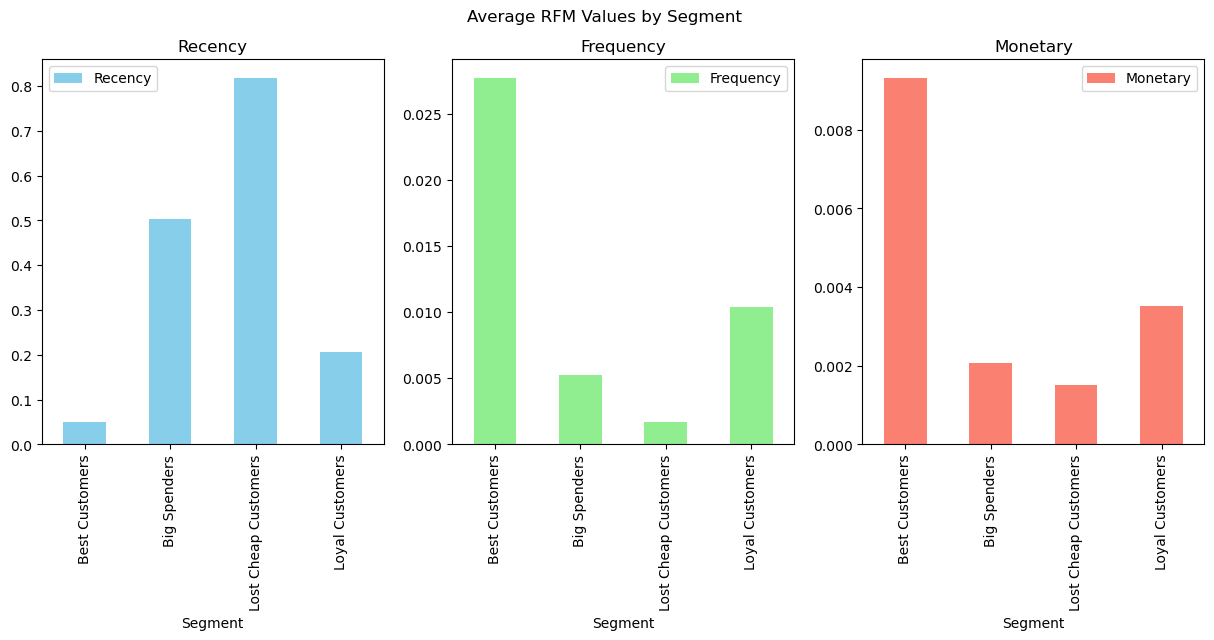

In [285]:
plt.figure(figsize=(12, 8))
segment_analysis[['Recency', 'Frequency', 'Monetary']].plot(kind='bar', subplots=True, layout=(1, 3), figsize=(15, 5), color=['skyblue', 'lightgreen', 'salmon'])
plt.suptitle('Average RFM Values by Segment')
plt.show()

<p></p>
<p>
<b>Cluster 0: Best Customers - Recent, frequent, and high-spending customers.</b><br>
<b>Cluster 1: Big Spenders - Moderately recent, substantial spenders, but less frequent buyers.</b><br>  
<b>Cluster 2: Loyal Customers - Moderately recent, regular buyers with moderate spending.</b><br>
<b>Cluster 3: Lost Cheap Customers - Least recent and infrequent buyers with low spending.</b><br>
</p>